## Import lib and config [run]


In [1]:
import numpy as np
import math
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

import cv2
import struct
import zipfile
import os

torch.manual_seed(42)
np.random.seed(42)

device = 'cpu'

## Upload & unzip the file [run]

In [2]:
zip_path = '/content/archive.zip'
extract_folder = '/content/mnist_data/'

os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

extracted_files = os.listdir(extract_folder)
print(f"Extracted files: {extracted_files}")

Extracted files: ['t10k-images.idx3-ubyte', 't10k-labels-idx1-ubyte', 't10k-labels.idx1-ubyte', 'train-images.idx3-ubyte', 'train-labels.idx1-ubyte', 'train-labels-idx1-ubyte', 't10k-images-idx3-ubyte', 'train-images-idx3-ubyte']


## Load data [run]

In [3]:
data_dir = '/content/mnist_data'

def read_images(file_path):
    with open(file_path, 'rb') as f:
        magic, num_images, rows, cols = struct.unpack('>IIII', f.read(16))
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def read_labels(file_path):
    with open(file_path, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

train_images = read_images(os.path.join(data_dir, 'train-images.idx3-ubyte'))
train_labels = read_labels(os.path.join(data_dir, 'train-labels.idx1-ubyte'))

test_images = read_images(os.path.join(data_dir, 't10k-images.idx3-ubyte'))
test_labels = read_labels(os.path.join(data_dir, 't10k-labels.idx1-ubyte'))

print("Train images:", train_images.shape)
print("Train labels:", train_labels.shape)
print("Test images:", test_images.shape)
print("Test labels:", test_labels.shape)

Train images: (60000, 28, 28)
Train labels: (60000,)
Test images: (10000, 28, 28)
Test labels: (10000,)


## Data preprocessing [run]

In [4]:
# numpy -> torch + normalize [0,1]
train_X = torch.tensor(train_images, dtype=torch.float32) / 255.0
train_y = torch.tensor(train_labels, dtype=torch.long)

test_X = torch.tensor(test_images, dtype=torch.float32) / 255.0
test_y = torch.tensor(test_labels, dtype=torch.long)

# add channel: (N,1,28,28)
train_X = train_X.unsqueeze(1)
test_X = test_X.unsqueeze(1)

# split train / val (90% / 10%)
num_train = train_X.shape[0]
num_val = int(0.1 * num_train)
num_train_final = num_train - num_val

X_train = train_X[:num_train_final]
y_train = train_y[:num_train_final]

X_val = train_X[num_train_final:]
y_val = train_y[num_train_final:]

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)

batch_size = 64

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(test_X,  test_y), batch_size=batch_size, shuffle=False)

print("Batches: train =", len(train_loader), "val =", len(val_loader), "test =", len(test_loader))

Train: torch.Size([54000, 1, 28, 28]) torch.Size([54000])
Val: torch.Size([6000, 1, 28, 28]) torch.Size([6000])
Batches: train = 844 val = 94 test = 157


## Custom classes: Linear, ReLU, Dropout, Flatten, Adam [run]

In [5]:
class Linear:
    def __init__(self, in_features, out_features):
        limit = 1.0 / math.sqrt(in_features)
        W = torch.empty(out_features, in_features).uniform_(-limit, limit)
        b = torch.zeros(out_features)
        self.W = W.requires_grad_(True)
        self.b = b.requires_grad_(True)

    def forward(self, x):
        return x @ self.W.T + self.b

    def __call__(self, x):
        return self.forward(x)

    def parameters(self):
        return [self.W, self.b]


class ReLU:
    def forward(self, x):
        return torch.clamp(x, min=0.0)

    def __call__(self, x):
        return self.forward(x)


class Dropout:
    def __init__(self, p=0.5):
        self.p = p
        self.training = True

    def forward(self, x):
        if (not self.training) or self.p == 0.0:
            return x
        mask = (torch.rand_like(x) > self.p).float()
        return x * mask / (1.0 - self.p)

    def __call__(self, x):
        return self.forward(x)


class Flatten:
    def forward(self, x):
        return x.view(x.size(0), -1)

    def __call__(self, x):
        return self.forward(x)

# loss function for multi-class classification (for backward)
class SoftmaxCrossEntropy:
    def __call__(self, logits, targets):
        # logits: (B,C), targets: (B,)
        log_probs = logits - torch.logsumexp(logits, dim=1, keepdim=True)
        loss = -log_probs[torch.arange(logits.size(0)), targets].mean()
        return loss


def softmax(logits):
    max_vals, _ = logits.max(dim=1, keepdim=True)         # (B,1)
    shifted = logits - max_vals                           # (B,C)

    exp_vals = torch.exp(shifted)                         # (B,C)
    sums = exp_vals.sum(dim=1, keepdim=True)              # (B,1)
    probs = exp_vals / sums                               # (B,C)
    return probs

class AdamOptimizer:
    def __init__(self, params, lr=1e-3, betas=(0.9,0.999), eps=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1
        lr_t = self.lr * ((1 - self.beta2**self.t)**0.5 / (1 - self.beta1**self.t))
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            g = p.grad
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * g
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (g * g)
            m_hat = self.m[i]
            v_hat = self.v[i]
            p.data -= lr_t * m_hat / (v_hat.sqrt() + self.eps)

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()

## Custom Conv2d & MaxPool2D

In [7]:
class Conv2dCustom:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        if isinstance(kernel_size, int):
            kH = kW = kernel_size
        else:
            kH, kW = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kH = kH
        self.kW = kW
        self.stride = stride
        self.padding = padding

        limit = 1.0 / math.sqrt(in_channels * kH * kW)
        W = torch.empty(out_channels, in_channels, kH, kW).uniform_(-limit, limit)
        b = torch.zeros(out_channels)
        self.W = W.requires_grad_(True)
        self.b = b.requires_grad_(True)

    def _pad(self, x):
        if self.padding == 0:
            return x
        B, C, H, W = x.shape
        p = self.padding
        x_padded = torch.zeros(B, C, H + 2*p, W + 2*p, dtype=x.dtype)
        x_padded[:, :, p:p+H, p:p+W] = x
        return x_padded

    def forward(self, x):
        x = self._pad(x)          # (B, C, Hp, Wp)
        B, C_in, Hp, Wp = x.shape
        kH, kW = self.kH, self.kW
        s = self.stride

        x_unf = x.unfold(2, kH, s).unfold(3, kW, s)
        B, C_in, H_out, W_out, kH, kW = x_unf.shape

        # (B, C_in*kH*kW, H_out*W_out)
        patches = x_unf.reshape(B, C_in * kH * kW, H_out * W_out)

        # W_flat: (C_out, C_in*kH*kW)
        W_flat = self.W.view(self.out_channels, -1)      # (C_out, C_in*kH*kW)
        W_batch = W_flat.unsqueeze(0).expand(B, -1, -1)  # (B, C_out, C_in*kH*kW)

        out = torch.matmul(W_batch, patches)             # (B, C_out, H_out*W_out)
        out = out + self.b.view(1, -1, 1)                # Add bias
        out = out.view(B, self.out_channels, H_out, W_out)
        return out

    def __call__(self, x):
        return self.forward(x)

    def parameters(self):
        return [self.W, self.b]


class MaxPool2D:
    def __init__(self, kernel_size=2, stride=2):
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        B, C, H, W = x.shape
        k = self.kernel_size
        s = self.stride

        # (B, C, H_out, W_out, k, k)
        x_unf = x.unfold(2, k, s).unfold(3, k, s)
        B, C, H_out, W_out, k, k = x_unf.shape

        patches = x_unf.reshape(B, C, H_out, W_out, k * k)  # (B,C,H_out,W_out,k*k)
        out = patches.max(dim=-1).values                    # (B,C,H_out,W_out)
        return out

    def __call__(self, x):
        return self.forward(x)

## MLPModel & CNNModel [run]


### MLPModel (for Model 1 & 2) [run]

Flatten → (Linear → ReLU → Dropout) × N → Linear (выход)

In [10]:
class MLPModel:
    def __init__(self, input_dim=28*28, hidden_dims=[128], num_classes=10, dropout_p=0.0):
        self.flatten = Flatten()
        self.hidden_layers = []
        self.activations = []
        self.dropouts = []

        prev_dim = input_dim
        for h in hidden_dims:
            fc = Linear(prev_dim, h)
            act = ReLU()
            do  = Dropout(dropout_p)
            self.hidden_layers.append(fc)
            self.activations.append(act)
            self.dropouts.append(do)
            prev_dim = h

        self.output = Linear(prev_dim, num_classes)
        self.criterion = SoftmaxCrossEntropy()

    def set_training(self, mode: bool):
        for d in self.dropouts:
            d.training = mode

    def forward(self, x):
        x = self.flatten(x)  # (B,1,28,28)->(B,784)
        for fc, act, do in zip(self.hidden_layers, self.activations, self.dropouts):
            x = fc(x)
            x = act(x)
            x = do(x)
        x = self.output(x)
        return x

    def __call__(self, x):
        return self.forward(x)

    def loss(self, x, y):
        logits = self.forward(x)
        return self.criterion(logits, y)

    def predict_proba(self, x):
        logits = self.forward(x)
        return softmax(logits)

    def predict(self, x):
        probs = self.predict_proba(x)
        return probs.argmax(dim=1)

    def parameters(self):
        params = []
        for fc in self.hidden_layers:
            params += fc.parameters()
        params += self.output.parameters()
        return params

### CNNModel (Model 3 & 4)

Conv2D → ReLU → MaxPool → Conv2D → ReLU → MaxPool → Flatten → Linear → ReLU → Dropout → Linear (выход)



In [11]:
class CNNModel:
    def __init__(self,
                 num_classes=10,
                 conv_channels=[8, 16],
                 kernel_size=3,
                 pool_size=2,
                 fc_dim=128,
                 dropout_p=0.5):
        # conv1, conv2
        self.conv1 = Conv2dCustom(1, conv_channels[0], kernel_size=kernel_size, padding=1)
        self.conv2 = Conv2dCustom(conv_channels[0], conv_channels[1], kernel_size=kernel_size, padding=1)
        self.relu1 = ReLU()
        self.relu2 = ReLU()
        self.pool1 = MaxPool2D(kernel_size=pool_size, stride=pool_size)
        self.pool2 = MaxPool2D(kernel_size=pool_size, stride=pool_size)

        self.flatten = Flatten()
        conv_output_dim = conv_channels[1] * 7 * 7

        self.fc1 = Linear(conv_output_dim, fc_dim)
        self.relu_fc = ReLU()
        self.dropout = Dropout(dropout_p)
        self.fc2 = Linear(fc_dim, num_classes)

        self.criterion = SoftmaxCrossEntropy()

    def set_training(self, mode: bool):
        self.dropout.training = mode

    def forward(self, x):
        # x: (B,1,28,28)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu_fc(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def __call__(self, x):
        return self.forward(x)

    def loss(self, x, y):
        logits = self.forward(x)
        return self.criterion(logits, y)

    def predict_proba(self, x):
        logits = self.forward(x)
        return softmax(logits)

    def predict(self, x):
        probs = self.predict_proba(x)
        return probs.argmax(dim=1)

    def parameters(self):
        params = []
        # conv params
        params += self.conv1.parameters()
        params += self.conv2.parameters()
        # fc params
        params += self.fc1.parameters()
        params += self.fc2.parameters()
        return params

## Train / Eval / Fit [run]

### Helpers for train/fit/evaluate/paint roc [run]

In [12]:
def evaluate_accuracy(model, data_loader):
    correct, total = 0, 0
    model.set_training(False)
    with torch.no_grad():
        for X, y in data_loader:
            preds = model.predict(X)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct / total


def train_one_epoch(model, optimizer, data_loader):
    model.set_training(True)
    total_loss = 0.0
    total_samples = 0

    for X, y in data_loader:
        loss = model.loss(X, y)
        optimizer.zero_grad()
        loss.backward()   # pytorch autograd
        optimizer.step()

        bs = y.size(0)
        total_loss += loss.item() * bs
        total_samples += bs

    return total_loss / total_samples


def fit_model(model, train_loader, val_loader, lr=1e-3, epochs=5):
    optimizer = AdamOptimizer(model.parameters(), lr=lr)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc'  : [],
    }

    for epoch in range(1, epochs+1):
        train_loss = train_one_epoch(model, optimizer, train_loader)
        train_acc  = evaluate_accuracy(model, train_loader)
        val_acc    = evaluate_accuracy(model, val_loader)

        # compute val_loss
        model.set_training(False)
        val_loss_total, val_n = 0.0, 0
        with torch.no_grad():
            for Xv, yv in val_loader:
                l = model.loss(Xv, yv)
                val_loss_total += l.item() * yv.size(0)
                val_n += yv.size(0)
        val_loss = val_loss_total / val_n

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch:02d} | "
              f"Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f} | "
              f"Train acc: {train_acc:.4f} | Val acc: {val_acc:.4f}")

    return history

In [13]:
def collect_scores_for_class(model, data_loader, positive_class=0):
    model.set_training(False)
    all_scores = []
    all_labels = []
    with torch.no_grad():
        for X, y in data_loader:
            probs = model.predict_proba(X)         # (B,10)
            scores = probs[:, positive_class]      # (B,)
            labels_bin = (y == positive_class).long()
            all_scores.append(scores)
            all_labels.append(labels_bin)
    y_true = torch.cat(all_labels)
    y_score = torch.cat(all_scores)
    return y_true, y_score


def compute_roc_auc(y_true_bin: torch.Tensor,
                    y_score: torch.Tensor,
                    num_thresholds: int = 200):
    """
    Custom ROC & AUC (one-vs-rest).
    """
    y_true_np = y_true_bin.cpu().numpy()
    y_score_np = y_score.cpu().numpy()

    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    tprs = []
    fprs = []

    for thr in thresholds:
        preds = (y_score_np >= thr).astype(int)
        TP = np.logical_and(preds == 1, y_true_np == 1).sum()
        FP = np.logical_and(preds == 1, y_true_np == 0).sum()
        TN = np.logical_and(preds == 0, y_true_np == 0).sum()
        FN = np.logical_and(preds == 0, y_true_np == 1).sum()

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0

        tprs.append(TPR)
        fprs.append(FPR)

    fprs = np.array(fprs)
    tprs = np.array(tprs)

    order = np.argsort(fprs)
    fprs = fprs[order]
    tprs = tprs[order]

    auc = 0.0
    for i in range(1, len(fprs)):
        dx = fprs[i] - fprs[i-1]
        avg_height = (tprs[i] + tprs[i-1]) / 2.0
        auc += dx * avg_height

    return fprs, tprs, auc


def plot_roc_curve(fpr, tpr, auc, model_name, positive_class=0):
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
    plt.plot([0,1], [0,1], 'k--', label="Random")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC for {model_name}, class {positive_class} vs rest")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


In [14]:
def train_eval_roc(model, model_name, train_loader, val_loader, test_loader,
                   lr=1e-3, epochs=5, positive_class=0):
    print(f"\n=== {model_name} ===")
    history = fit_model(model, train_loader, val_loader, lr=lr, epochs=epochs)

    # Test accuracy
    test_acc = evaluate_accuracy(model, test_loader)
    print(f"{model_name} - Test accuracy: {test_acc:.4f}")

    # ROC/AUC on test (one-vs-rest for class chosen)
    y_true_bin, y_score = collect_scores_for_class(
        model, test_loader, positive_class=positive_class
    )
    fpr, tpr, auc = compute_roc_auc(y_true_bin, y_score, num_thresholds=200)
    print(f"{model_name} - ROC AUC (class {positive_class} vs rest): {auc:.4f}")

    plot_roc_curve(fpr, tpr, auc, model_name, positive_class=positive_class)

    return history, test_acc, (fpr, tpr, auc)

In [15]:
num_epochs_mlp = 5
num_epochs_cnn = 5
positive_class = 0   # ví dụ: đánh giá ROC cho class "0"

models = []
histories = []
test_accuracies = []
roc_results = []

### Model 1


=== Model 1: MLP [128], no dropout ===
Epoch 01 | Train loss: 0.3689 | Val loss: 0.1803 | Train acc: 0.9389 | Val acc: 0.9505
Epoch 02 | Train loss: 0.1712 | Val loss: 0.1207 | Train acc: 0.9625 | Val acc: 0.9678
Epoch 03 | Train loss: 0.1184 | Val loss: 0.0986 | Train acc: 0.9749 | Val acc: 0.9707
Epoch 04 | Train loss: 0.0900 | Val loss: 0.0929 | Train acc: 0.9786 | Val acc: 0.9718
Epoch 05 | Train loss: 0.0714 | Val loss: 0.0845 | Train acc: 0.9854 | Val acc: 0.9763
Model 1: MLP [128], no dropout - Test accuracy: 0.9765
Model 1: MLP [128], no dropout - ROC AUC (class 0 vs rest): 0.9989


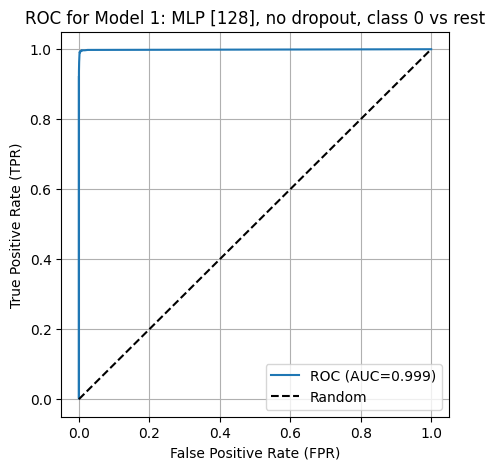

In [16]:
# Model 1
model1 = MLPModel(hidden_dims=[128], dropout_p=0.0)
hist1, acc1, roc1 = train_eval_roc(
    model1,
    "Model 1: MLP [128], no dropout",
    train_loader, val_loader, test_loader,
    lr=1e-3, epochs=num_epochs_mlp,
    positive_class=positive_class
)
models.append(model1)
histories.append(hist1)
test_accuracies.append(acc1)
roc_results.append(roc1)

### Model 2 [run the best]


=== Model 2: MLP [256], dropout=0.2 ===
Epoch 01 | Train loss: 0.3406 | Val loss: 0.1408 | Train acc: 0.9522 | Val acc: 0.9603
Epoch 02 | Train loss: 0.1507 | Val loss: 0.0985 | Train acc: 0.9712 | Val acc: 0.9730
Epoch 03 | Train loss: 0.1068 | Val loss: 0.0873 | Train acc: 0.9775 | Val acc: 0.9758
Epoch 04 | Train loss: 0.0828 | Val loss: 0.0711 | Train acc: 0.9850 | Val acc: 0.9788
Epoch 05 | Train loss: 0.0680 | Val loss: 0.0718 | Train acc: 0.9884 | Val acc: 0.9800
Model 2: MLP [256], dropout=0.2 - Test accuracy: 0.9765
Model 2: MLP [256], dropout=0.2 - ROC AUC (class 0 vs rest): 0.9994


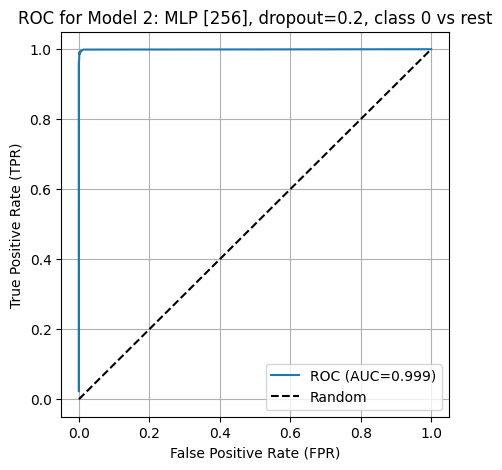

In [42]:
# Model 2
model2 = MLPModel(hidden_dims=[256], dropout_p=0.2)
hist2, acc2, roc2 = train_eval_roc(
    model2,
    "Model 2: MLP [256], dropout=0.2",
    train_loader, val_loader, test_loader,
    lr=1e-3, epochs=num_epochs_mlp,
    positive_class=positive_class
)
models.append(model2)
histories.append(hist2)
test_accuracies.append(acc2)
roc_results.append(roc2)

### Model 3


=== Model 3: CNN [8,16], fc=128, dropout=0.3 ===
Epoch 01 | Train loss: 0.6329 | Val loss: 0.2293 | Train acc: 0.9124 | Val acc: 0.9338
Epoch 02 | Train loss: 0.2729 | Val loss: 0.1545 | Train acc: 0.9433 | Val acc: 0.9573
Epoch 03 | Train loss: 0.2046 | Val loss: 0.1140 | Train acc: 0.9580 | Val acc: 0.9648
Epoch 04 | Train loss: 0.1686 | Val loss: 0.1164 | Train acc: 0.9589 | Val acc: 0.9650
Epoch 05 | Train loss: 0.1455 | Val loss: 0.1060 | Train acc: 0.9670 | Val acc: 0.9697
Model 3: CNN [8,16], fc=128, dropout=0.3 - Test accuracy: 0.9603
Model 3: CNN [8,16], fc=128, dropout=0.3 - ROC AUC (class 0 vs rest): 0.9993


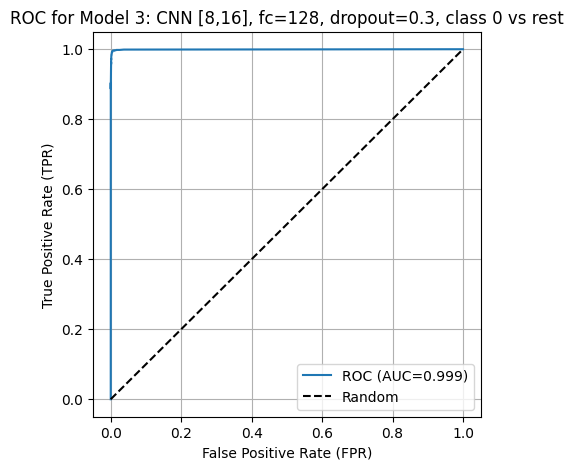

In [18]:
# Model 3
model3 = CNNModel(conv_channels=[8,16], fc_dim=128, dropout_p=0.3)
hist3, acc3, roc3 = train_eval_roc(
    model3,
    "Model 3: CNN [8,16], fc=128, dropout=0.3",
    train_loader, val_loader, test_loader,
    lr=1e-3, epochs=num_epochs_cnn,
    positive_class=positive_class
)
models.append(model3)
histories.append(hist3)
test_accuracies.append(acc3)
roc_results.append(roc3)

### Model 4


=== Model 4: CNN [16,32], fc=256, dropout=0.5 ===
Epoch 01 | Train loss: 0.4400 | Val loss: 0.1307 | Train acc: 0.9471 | Val acc: 0.9603
Epoch 02 | Train loss: 0.1894 | Val loss: 0.1081 | Train acc: 0.9595 | Val acc: 0.9682
Epoch 03 | Train loss: 0.1425 | Val loss: 0.0840 | Train acc: 0.9723 | Val acc: 0.9763
Epoch 04 | Train loss: 0.1162 | Val loss: 0.0879 | Train acc: 0.9740 | Val acc: 0.9743
Epoch 05 | Train loss: 0.0990 | Val loss: 0.0770 | Train acc: 0.9792 | Val acc: 0.9777
Model 4: CNN [16,32], fc=256, dropout=0.5 - Test accuracy: 0.9723
Model 4: CNN [16,32], fc=256, dropout=0.5 - ROC AUC (class 0 vs rest): 0.9983


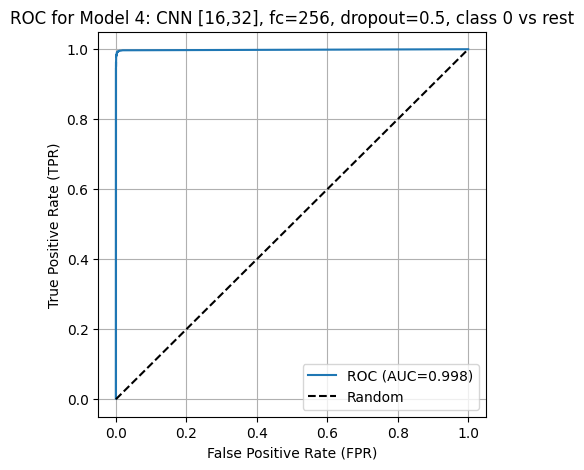

In [19]:
# Model 4
model4 = CNNModel(conv_channels=[16,32], fc_dim=256, dropout_p=0.5)
hist4, acc4, roc4 = train_eval_roc(
    model4,
    "Model 4: CNN [16,32], fc=256, dropout=0.5",
    train_loader, val_loader, test_loader,
    lr=1e-3, epochs=num_epochs_cnn,
    positive_class=positive_class
)
models.append(model4)
histories.append(hist4)
test_accuracies.append(acc4)
roc_results.append(roc4)

## Comparison chart

In [20]:
# Test accuracy
test_accuracies = []
for i, model in enumerate(models, start=1):
    acc = evaluate_accuracy(model, test_loader)
    test_accuracies.append(acc)
    print(f"Model {i} - Test accuracy: {acc:.4f}")

Model 1 - Test accuracy: 0.9765
Model 2 - Test accuracy: 0.9757
Model 3 - Test accuracy: 0.9603
Model 4 - Test accuracy: 0.9723


So we choose the model 2

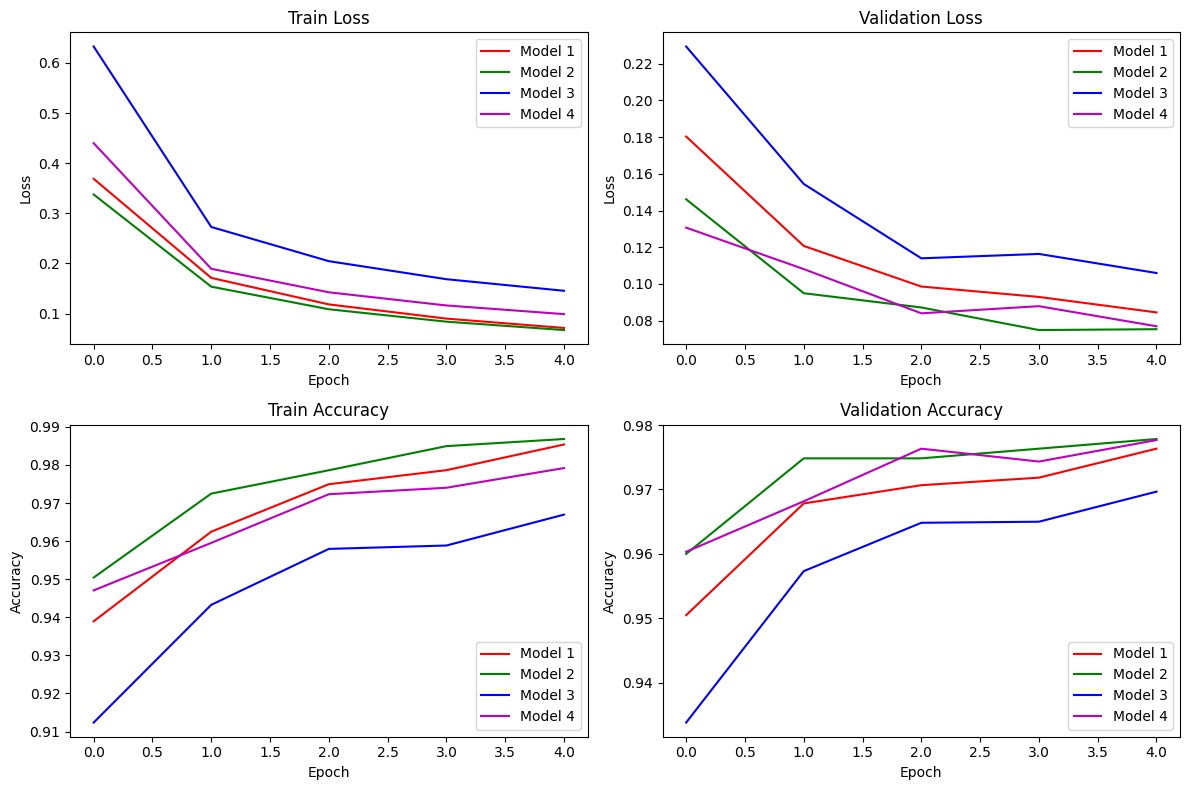

In [21]:
# Plot 4 model: train/val loss & acc
colors = ['r', 'g', 'b', 'm']
labels = [f"Model {i}" for i in range(1, 5)]

plt.figure(figsize=(12,8))

# Train loss
plt.subplot(2,2,1)
for i, hist in enumerate(histories):
    plt.plot(hist['train_loss'], color=colors[i], label=labels[i])
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Val loss
plt.subplot(2,2,2)
for i, hist in enumerate(histories):
    plt.plot(hist['val_loss'], color=colors[i], label=labels[i])
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Train acc
plt.subplot(2,2,3)
for i, hist in enumerate(histories):
    plt.plot(hist['train_acc'], color=colors[i], label=labels[i])
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Val acc
plt.subplot(2,2,4)
for i, hist in enumerate(histories):
    plt.plot(hist['val_acc'], color=colors[i], label=labels[i])
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Predict image [run]

In [22]:
best_model = model2
best_model.set_training(False)  # turn off dropout when predict

In [23]:
def preprocess_for_mnist(img, show_steps=False):
    """
    img: numpy 2D (H,W), grayscale (0..255)
    return: torch tensor (1,1,28,28), float32, normalized to [0,1]
    """
    # If image is color, convert to gray
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    step_imgs = {}

    step_imgs["original"] = img.copy()

    # Invert so digit becomes white on black background
    inv = 255 - img
    step_imgs["inverted"] = inv.copy()

    # Otsu threshold to get binary image
    _, th = cv2.threshold(inv, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    step_imgs["threshold"] = th.copy()

    # Find bounding box of digit
    coords = cv2.findNonZero(th)
    if coords is None:
        # no foreground, fallback: use full image
        crop = th
    else:
        x, y, w, h = cv2.boundingRect(coords)
        crop = th[y:y+h, x:x+w]
    step_imgs["cropped"] = crop.copy()

    # Resize with aspect ratio so max side = 20 pixels
    h, w = crop.shape
    if h > w:
        new_h = 20
        new_w = int(w * (20.0 / h))
    else:
        new_w = 20
        new_h = int(h * (20.0 / w))
    resized = cv2.resize(crop, (new_w, new_h), interpolation=cv2.INTER_AREA)
    step_imgs["resized"] = resized.copy()

    # Put into 28x28 canvas, centered
    canvas = np.zeros((28, 28), dtype=np.uint8)
    y0 = (28 - new_h) // 2
    x0 = (28 - new_w) // 2
    canvas[y0:y0+new_h, x0:x0+new_w] = resized
    step_imgs["final_28x28"] = canvas.copy()

    if show_steps:
        plt.figure(figsize=(10, 2))
        titles = ["original", "inverted", "threshold", "cropped", "resized", "final_28x28"]
        for i, t in enumerate(titles):
            plt.subplot(1, 6, i+1)
            plt.imshow(step_imgs[t], cmap="gray")
            plt.title(t)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    # Normalize to [0,1]
    canvas = canvas.astype(np.float32) / 255.0

    # To tensor (1,1,28,28)
    img_tensor = torch.from_numpy(canvas).unsqueeze(0).unsqueeze(0)
    return img_tensor

### Upload image [run]

Saving paint.png to paint (33).png
Uploaded file: paint (33).png
Original image shape: (907, 675)


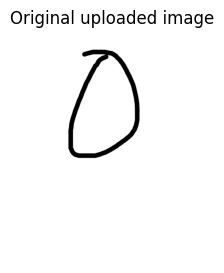

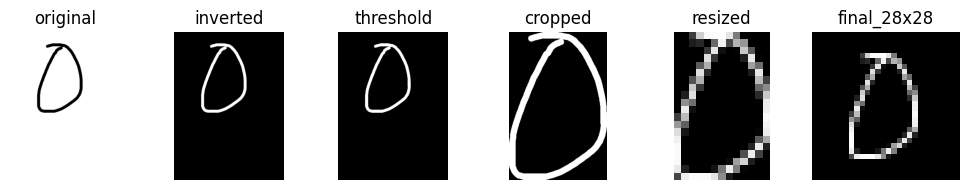

Preprocessed tensor shape: torch.Size([1, 1, 28, 28])
Predicted digit: 0
Class probabilities:
  0: 0.8568
  1: 0.0015
  2: 0.0828
  3: 0.0113
  4: 0.0001
  5: 0.0023
  6: 0.0008
  7: 0.0015
  8: 0.0040
  9: 0.0388


In [59]:
from google.colab import files

# 1. Upload file
uploaded = files.upload()

filename = next(iter(uploaded.keys()))
print("Uploaded file:", filename)

img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
print("Original image shape:", img.shape)

# show original image
plt.figure(figsize=(3,3))
plt.imshow(img, cmap='gray')
plt.title("Original uploaded image")
plt.axis('off')
plt.show()

# 5. preprocessing
img_tensor = preprocess_for_mnist(img, show_steps=True)
print("Preprocessed tensor shape:", img_tensor.shape)

# 6. predict by the best model
best_model.set_training(False)
with torch.no_grad():
    logits = best_model.forward(img_tensor)
    probs = torch.softmax(logits, dim=1)
    pred_class = probs.argmax(dim=1).item()
    # probs = softmax(logits)

print(f"Predicted digit: {pred_class}")
print("Class probabilities:")
for d in range(10):
    print(f"  {d}: {probs[0, d].item():.4f}")